# Проект: Линейные модели в машинном обучении

## 1. Введение

   Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

   Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. 

Необходимо создать две прогнозные модели для отбора бурёнок в поголовье:

- Первая будет прогнозировать возможный удой коровы (целевой признак **Удой**);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак **Вкус молока**).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным;

## 2. Загрузка и изучение данных

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

RANDOM_STATE = 42
sns.set()

### 2.1 Загрузка данных

In [58]:
df_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', ';')
df_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', ';')
df_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', ';')

Загрузил данные в датасеты df_main, df_dad, df_buy для файлов ferma_main.csv, ferma_dad.csv, cow_buy.csv

### 2.2 Изучение данных

In [59]:
df_main.columns = ['id',
 'удой',
 'эке',
 'сырой_протеин',
 'спо',
 'порода',
 'тип_пастбища',
 'порода_папы_быка',
 'жирность',
 'белок',
 'вкус_молока',
 'возраст']
df_dad.columns = ['id', 'имя_папы']
df_buy.columns = ['порода',
 'тип_пастбища',
 'порода_папы_быка',
 'имя_папы',
 'жирность',
 'белок',
 'возраст']
display(df_main.head(5))
display(df_dad.head(5))
display(df_buy.head(5))

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Переименовал колонки для всех трех датасетов по следующим правилам:
- приведение к нижнему регистру
- удаление упоминания по единицах измерения в конце имени колонки
- пробел заменется на подчеркивание
- имена колонок **текущая_жирность** и **текущий_уровень_белка** приведены к более общей форме **жирность** и **белок**

Сейчас имена колонок приведены к единому стандарту.
На первый взгляд содержимое колонок соответствует их наименованию.

На мой взгляд - датасеты df_main и df_dad надо объединить в один датасет df_main_with_dad который будет включать все информацию из df_main, включая имя папы коровы из df_dad для каждой коровы и далее оперировать уже полным датасетом df_main_with_dad вместо двух, его составляющих. Но сделать это надо после удаления возможных дубликатов и это будет сделано ниже.

## 3. Предобработка данных

### 3.1 Удаление дубликатов и объединение датафреймов df_main и df_dad

In [60]:
print(f'Обнаружены дубликаты: df_main: {df_main.duplicated().sum()}, df_dad: {df_dad.duplicated().sum()}, df_buy: {df_buy.duplicated().sum()}')
df_main.drop_duplicates(inplace=True)
df_buy.drop_duplicates(inplace=True)
df_main_with_dad = df_main.join(df_dad, how='inner', rsuffix='_dad')
df_main_with_dad = df_main_with_dad.loc[:, df_main_with_dad.columns!='id_dad']
df_main_with_dad.info()
df_main_with_dad.head()

Обнаружены дубликаты: df_main: 5, df_dad: 0, df_buy: 4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                629 non-null    int64 
 1   удой              629 non-null    int64 
 2   эке               629 non-null    object
 3   сырой_протеин     629 non-null    int64 
 4   спо               629 non-null    object
 5   порода            629 non-null    object
 6   тип_пастбища      629 non-null    object
 7   порода_папы_быка  629 non-null    object
 8   жирность          629 non-null    object
 9   белок             629 non-null    object
 10  вкус_молока       629 non-null    object
 11  возраст           629 non-null    object
 12  имя_папы          629 non-null    object
dtypes: int64(3), object(10)
memory usage: 85.0+ KB


,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет,Буйный
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет,Соловчик
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет,Барин
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет,Буйный
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет,Барин


- для датасетов df_main и df_buy обнаружены дубликаты и удалены
- датасеты df_main и df_dad объединены в один датасет df_main_with_dad и он далее берется в работу вместо предыдущих двух. Индекс в новой таблице взят из таблицы df_main.

In [61]:
### 3.2 Приведение имен колонок к общему виду, приведение типов и корректировка значений категориальных параметров

In [62]:
df_main_with_dad.info()
df_buy.info()

df_main_float_col_list = ['эке', 'спо', 'жирность', 'белок']
df_main_str_col_list = ['порода', 'порода_папы_быка', 'вкус_молока', 'возраст', 'тип_пастбища', 'имя_папы']
df_main_with_dad['тип_пастбища'] = df_main_with_dad['тип_пастбища'].str.lower()
df_main_with_dad['тип_пастбища'] = df_main_with_dad['тип_пастбища'].replace('равнинные', 'равнинное')
df_main_with_dad['порода_папы_быка'] = df_main_with_dad['порода_папы_быка'].replace('Айдиалл', 'Айдиал')
df_main_with_dad.drop(df_main_with_dad.loc[df_main_with_dad['удой']==45616].index, inplace=True)
df_main_with_dad[df_main_float_col_list]  = df_main_with_dad[df_main_float_col_list].replace(',', '.', regex=True).astype('float')
df_main_with_dad[df_main_str_col_list]  = df_main_with_dad[df_main_str_col_list].astype('string')
print(df_main_with_dad['тип_пастбища'].unique())
print(df_main_with_dad['тип_пастбища'].unique())
df_buy_float_col_list = ['жирность', 'белок']
df_buy_str_col_list = ['порода', 'порода_папы_быка', 'имя_папы', 'возраст', 'тип_пастбища']
df_buy[df_buy_float_col_list]  = df_buy[df_buy_float_col_list].replace(',', '.', regex=True).astype('float')
df_buy[df_buy_str_col_list]    = df_buy[df_buy_str_col_list].astype('string')
display(df_main_with_dad.head(5))
display(df_buy.head(5))
df_main_with_dad.info()
df_buy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                629 non-null    int64 
 1   удой              629 non-null    int64 
 2   эке               629 non-null    object
 3   сырой_протеин     629 non-null    int64 
 4   спо               629 non-null    object
 5   порода            629 non-null    object
 6   тип_пастбища      629 non-null    object
 7   порода_папы_быка  629 non-null    object
 8   жирность          629 non-null    object
 9   белок             629 non-null    object
 10  вкус_молока       629 non-null    object
 11  возраст           629 non-null    object
 12  имя_папы          629 non-null    object
dtypes: int64(3), object(10)
memory usage: 85.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   удой              628 non-null    int64  
 2   эке               628 non-null    float64
 3   сырой_протеин     628 non-null    int64  
 4   спо               628 non-null    float64
 5   порода            628 non-null    string 
 6   тип_пастбища      628 non-null    string 
 7   порода_папы_быка  628 non-null    string 
 8   жирность          628 non-null    float64
 9   белок             628 non-null    float64
 10  вкус_молока       628 non-null    string 
 11  возраст           628 non-null    string 
 12  имя_папы          628 non-null    string 
dtypes: float64(4), int64(3), string(6)
memory usage: 68.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column            Non

Первичный анализ датасетов с помощью метода **info** показал, что почти все поля (кроме индексного и нескольких других)  имеют тип **object**, хотя их реальные типы float, string. Были выполнены приведения типов этих полей к двум вышеуказанным, при этом были еще проведены ряд преобразований:
- во всех колонках, содержащих числа с плавающей точкой, была заменена , на . как символ разделителя целой и дробной части
- содержимое колонки **тип_пастбища** в df_main_with_dad было приведено к нижнему регистру, чтобы соотвествовать формату данных в этой же колонке в датасете df_buy
- в колонке **тип_пастбища** в df_main_with_dad была произведена замена значений **равнинные** на **равнинное**, чтобы соответствовать набору из двух значений в этой категории:
    - равнинное
    - холмистое
- в колонке **порода_папы_быка** в df_main_with_dad была произведена замена значений **Айдиалл** на **Айдиал**, чтобы соответствовать набору из двух значений в этой категории:
    - Айдиал
    - Соверин

Окончательный анализ на этой стадии показал, что датасеты не имеют пропусков, и колонки в них имеют тип, соответствующий их содержанию.

## 4. Исследовательский анализ данных

### 4.1 Cтатистический анализ всех признаков

In [63]:
print('Статистика количественных параметров для df_main_with_dad')
display(df_main_with_dad.select_dtypes(include=np.number).describe().T)
print('Статистика категориальных параметров для df_main_with_dad')
display(df_main_with_dad.select_dtypes(exclude=np.number).describe())
print('Статистика количественных параметров для df_buy')
display(df_buy.select_dtypes(include=np.number).describe().T)
print('Статистика категориальных параметров для df_buy')
display(df_buy.select_dtypes(exclude=np.number).describe().T)

print(list(df_main_with_dad['порода_папы_быка'].unique()))
print(list(df_buy['порода_папы_быка'].unique()))

print(list(df_main_with_dad['порода'].unique()))
print(list(df_buy['порода'].unique()))

Статистика количественных параметров для df_main_with_dad


,count,mean,std,min,25%,50%,75%,max
id,628.0,315.474522,181.475367,1.000,158.750,315.500,472.250,629.000
удой,628.0,6125.968153,475.857053,5204.000,5749.750,6132.500,6501.000,7222.000
эке,628.0,14.548726,1.301777,10.900,13.500,14.700,15.600,16.800
сырой_протеин,628.0,1923.759554,182.832816,1660.000,1771.750,1888.000,2062.250,2349.000
спо,628.0,0.913089,0.032221,0.840,0.890,0.930,0.940,0.960
жирность,628.0,3.604268,0.168093,2.990,3.590,3.650,3.720,3.750
белок,628.0,3.075670,0.002551,3.069,3.074,3.076,3.077,3.085


Статистика категориальных параметров для df_main_with_dad


,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст,имя_папы
count,628,628,628,628,628,628
unique,2,2,2,2,2,4
top,Вис Бик Айдиал,холмистое,Айдиал,вкусно,более_2_лет,Барин
freq,372,350,317,370,518,240


Статистика количественных параметров для df_buy


,count,mean,std,min,25%,50%,75%,max
жирность,16.0,3.571875,0.141620,3.340,3.4150,3.5850,3.69250,3.770
белок,16.0,3.068250,0.011264,3.046,3.0595,3.0735,3.07675,3.081


Статистика категориальных параметров для df_buy


,count,unique,top,freq
порода,16,2,РефлешнСоверинг,8
тип_пастбища,16,2,холмистое,8
порода_папы_быка,16,2,Соверин,10
имя_папы,16,4,Буйный,7
возраст,16,2,более_2_лет,11


['Айдиал', 'Соверин']
['Айдиал', 'Соверин']
['Вис Бик Айдиал', 'РефлешнСоверинг']
['Вис Бик Айдиал', 'РефлешнСоверинг']


Статанализ количественных и категориальных параметров для датасетов **df_main_with_dad, df_buy** показал:

    - количественные признаки показывают характер нормального распределения (более подробно можно будет сказать после анализа графиков)
    - категориальные признаки показывают наличие определенных категорий и количество уникальных значений этих категорий соответствует количеству уникальных значений в других таблицах
  

### 4.2 Построение графиков для каждого признака

#### 4.2.1 df_main_with_dad количественные параметры

Index(['белок', 'жирность', 'спо', 'сырой_протеин', 'удой', 'эке'], dtype='object')


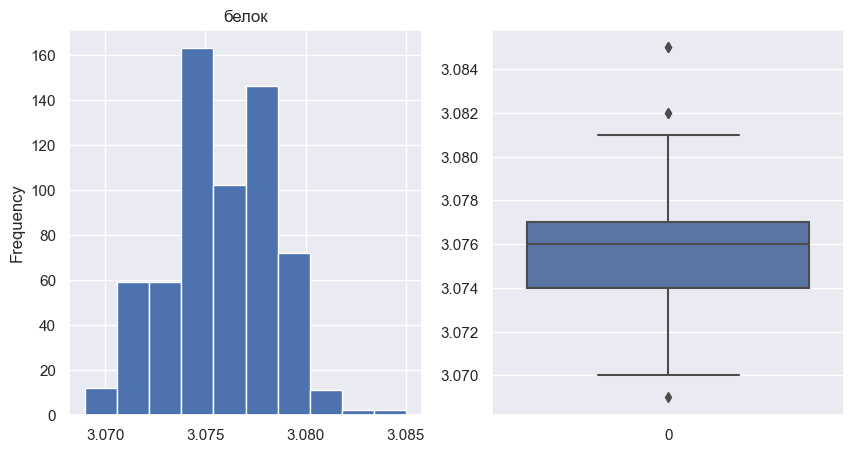

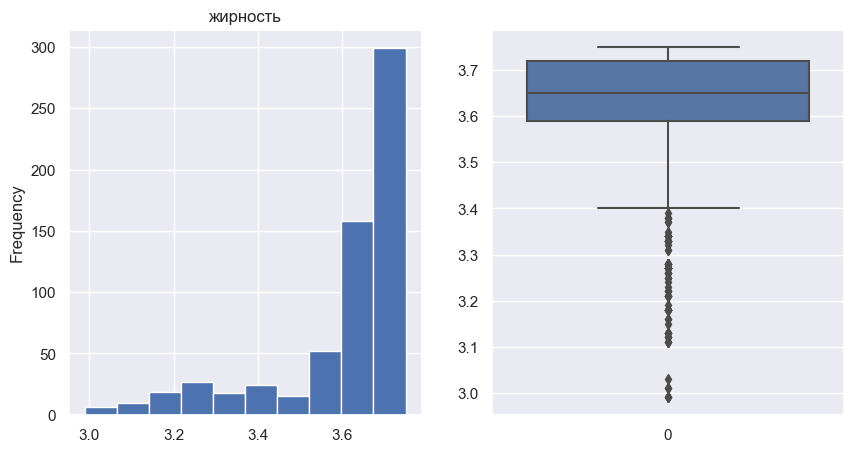

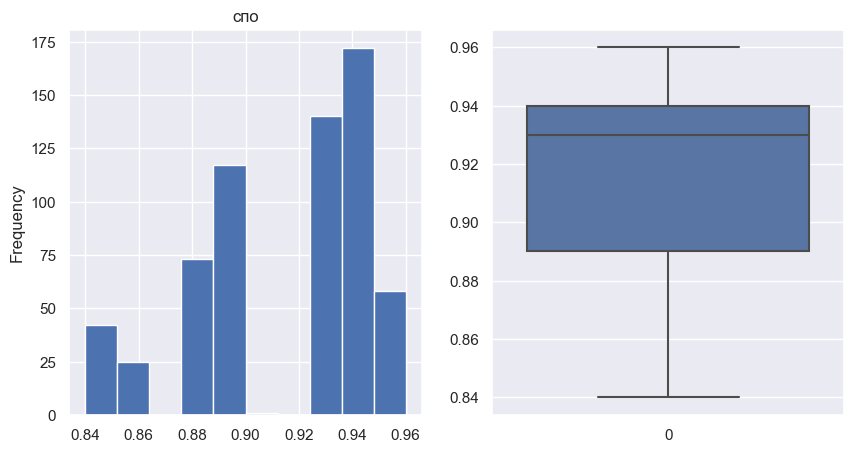

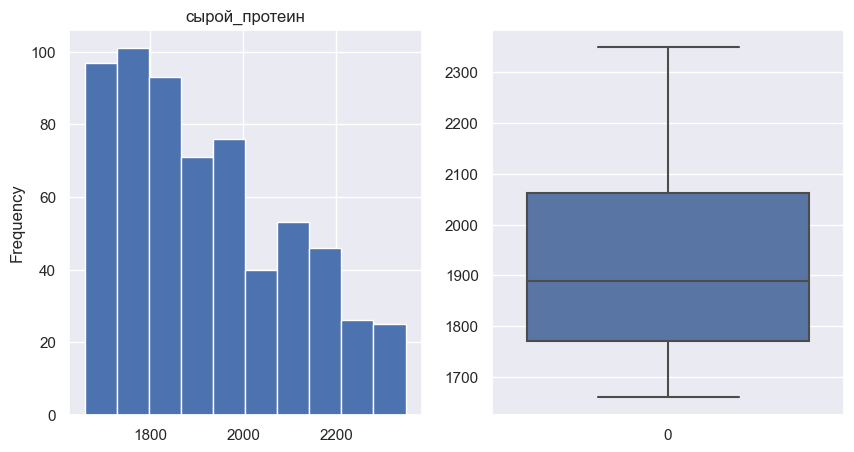

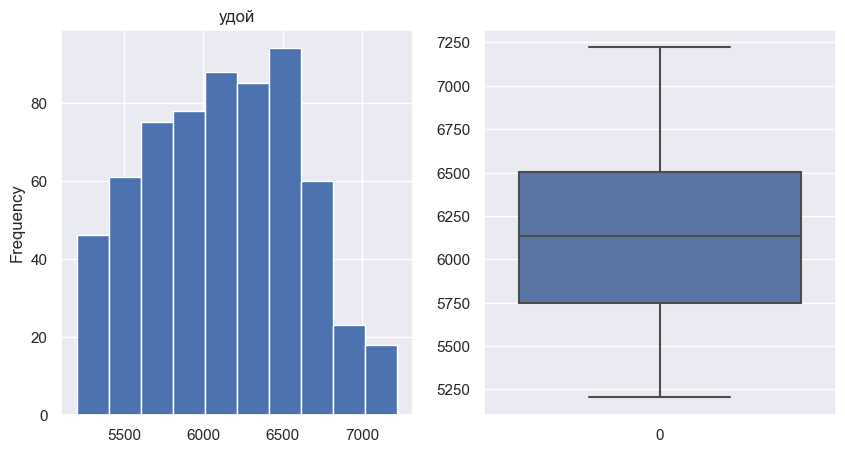

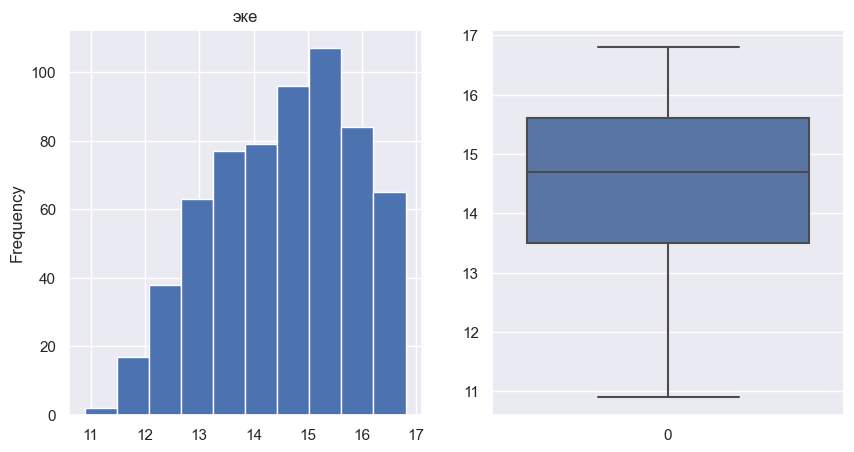

In [64]:
#cols = [c for c in df_main.columns if df_main[c].dtype.name not in ['string', 'category'] and c != 'id']
def plot_sub_plot_hist_boxplot(df):
    for col in df.columns:
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(data=df[col], ax = axes[1])
        plt.show()
        
df_main_numeric = df_main_with_dad.select_dtypes(include=np.number)
df_main_numeric = df_main_numeric[df_main_numeric.columns.difference(['id'])]
print(df_main_numeric.columns)
plot_sub_plot_hist_boxplot(df_main_numeric)


Для количественных параметров - **'белок', 'жирность', 'спо', 'сырой_протеин', 'удой', 'эке'**. Для каждой колонки были построены гистограмма (с дефолтовым количеством бинов) и boxplot. Для колонки **удой** имеет место большой выброс = 45616 в единичном экземпляре, который принят за ошибку ввода данных и удален (Изменения внесены в п 3. Предобработка данных). Остальные распределения выглядят нормально, распределения **эке** и **белок** близки к нормальному, остальные - нет. Для параметра **жирность** имеют место выбросы ниже первого квантиля, для параметра **белок** имеет место небольшое количество выбросов, для остальных выбросов нет.


#### 4.2.2 df_main_with_dad категориальные параметры

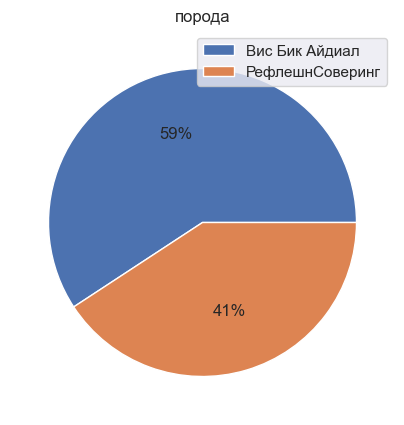

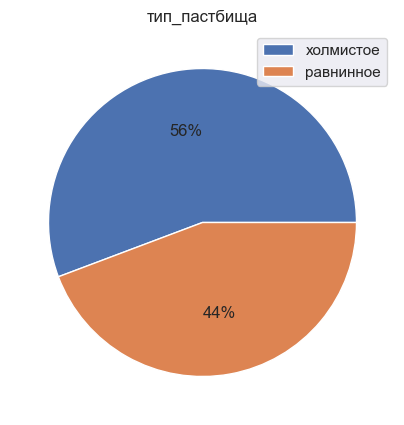

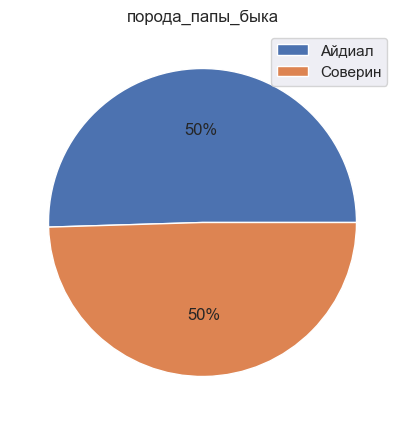

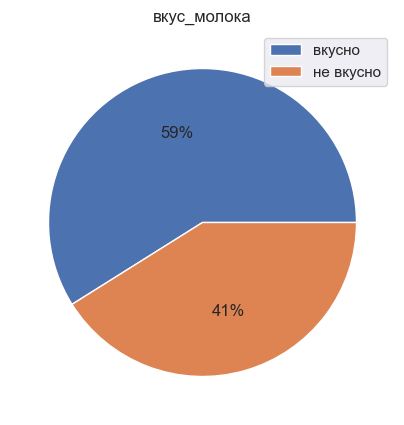

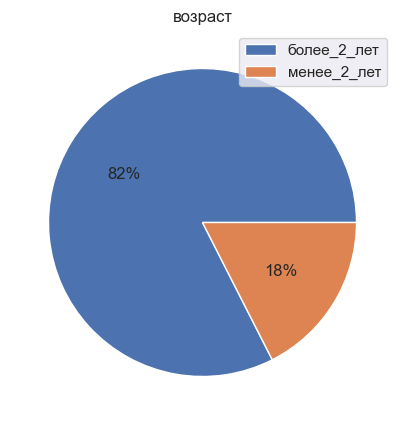

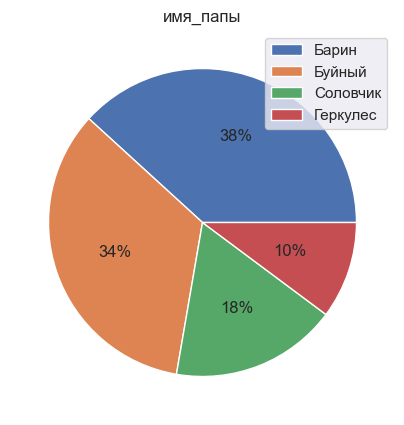

In [65]:
def plot_pie_plot_for_columns(df):
    for col in df.columns:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.show()

df_main_notnumeric = df_main_with_dad.select_dtypes(exclude=np.number)
plot_pie_plot_for_columns(df_main_notnumeric)

Представлены pie диаграммы для категориальных параметров датафрейма df_main_with_dad.

#### 4.2.4 df_buy количественные параметры

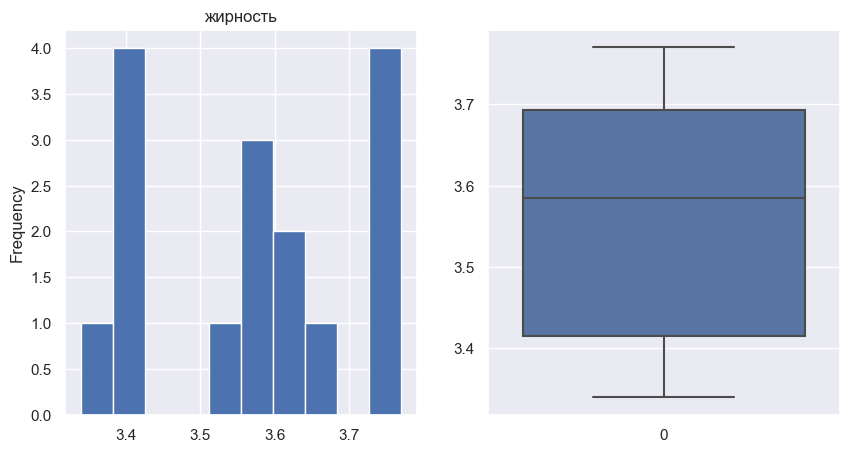

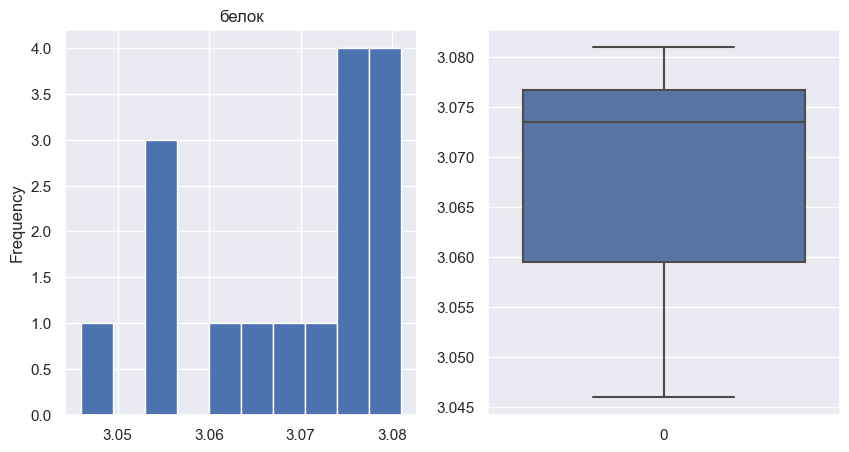

In [66]:
def plot_plot_bar(df):
    for col in df.columns:
        df[col].plot(kind="hist", title=col, figsize=(10, 5))
        plt.show()

plot_sub_plot_hist_boxplot(df_buy.select_dtypes(include=np.number))

Построены графики для количественных параметров датафрейма df_buy - заметных выбросов нет

#### 4.2.5 df_buy категориальные параметры

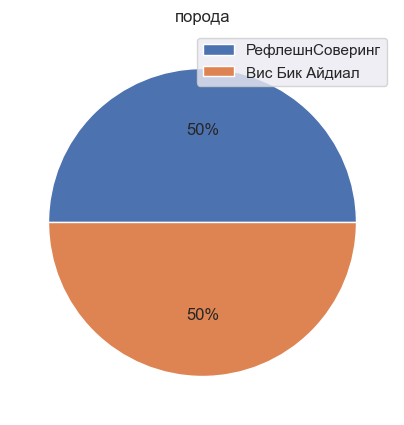

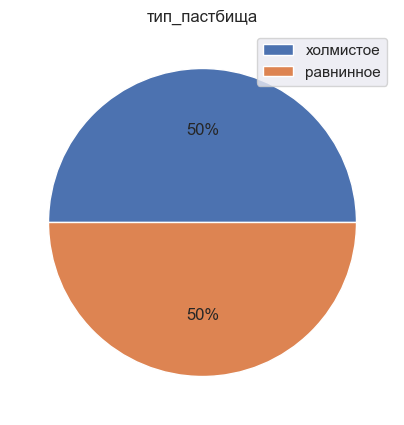

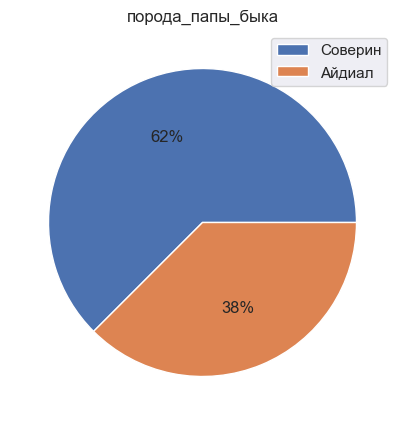

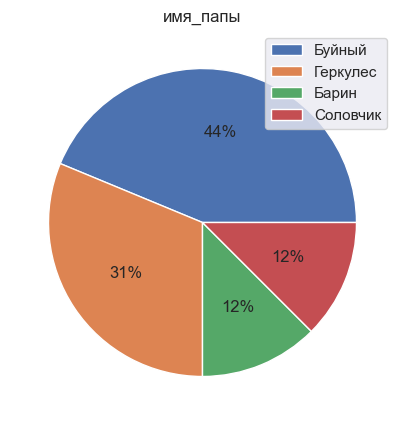

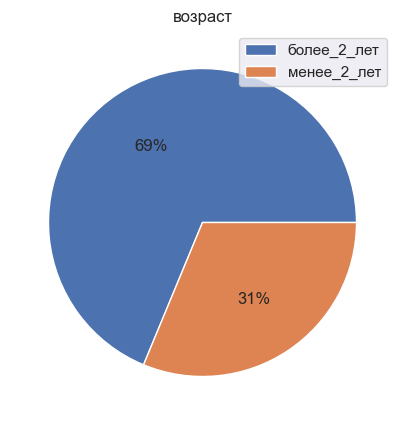

In [67]:
plot_pie_plot_for_columns(df_buy.select_dtypes(exclude=np.number))

### 4.3 Выводы о данных

- удалены дубликаты для таблиц df_main и df_buy и далее они объедиены в одну таблицу df_main_with_dad
- для колонки **удой** датасета df_main_with_dad имеет место большой выброс = 45616 в единичном экземпляре, который принят за ошибку ввода данных и удален
- по остальным количественным параметрам заметных выбросов не обнаружено
- пропусков в данных нет
- для категориальных данных были произведено приведение к нижнему регистру и исправлены ошибки при вводе признаков некоторых категорий так, чтобы во всех таблицах они были представлены единообразно
- графики boxplot для некоторых количественых признаков показывают распределение, близкое к нормальному (mean ~ median) а для некоторых не показывают такого распределения

## 5. Проведение корреляционного анализа признаков в датасете **ferma_main.csv**

### 5.1 Изучение взаимосвязи между признаками

На данном этапе предлагается изучить связь только между количествеными признаками, используя кореляционную матрицу и диаграммы рассеяния. Для начала выделим список колонок, содержащих количественные признаки для датасетов df_main_with_dad и df_buy и построим по ним корреляционную матрицу и heatmap

,белок,жирность,спо,сырой_протеин,удой,эке
0,3.076,3.58,0.890,1743,5863,14.2
1,3.079,3.54,0.890,2138,5529,12.8
2,3.074,3.59,0.885,1854,5810,14.0
3,3.075,3.40,0.885,2012,5895,12.4
4,3.073,3.73,0.885,1675,5302,12.8


,жирность,белок
0,3.58,3.076
1,3.54,3.081
2,3.59,3.074
3,3.40,3.061
4,3.64,3.074


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,-0.026542,0.073718,0.226802,0.002966,-0.008939
жирность,-0.026542,1.000000,0.629098,0.357793,0.600902,0.637279
спо,0.073718,0.629098,1.000000,0.446332,0.806339,0.749007
сырой_протеин,0.226802,0.357793,0.446332,1.000000,0.446731,0.387875
удой,0.002966,0.600902,0.806339,0.446731,1.000000,0.765098
эке,-0.008939,0.637279,0.749007,0.387875,0.765098,1.000000


,жирность,белок
жирность,1.000000,-0.295376
белок,-0.295376,1.000000


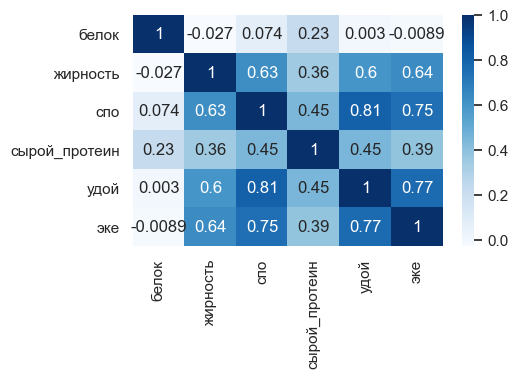

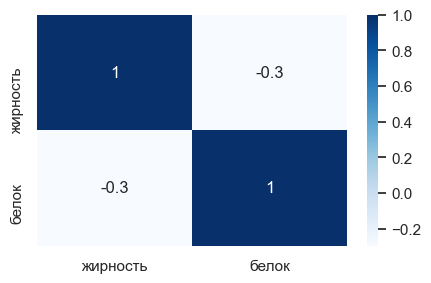

In [68]:
df_main_numeric = df_main_with_dad.select_dtypes(include=np.number)
df_main_numeric = df_main_numeric[df_main_numeric.columns.difference(['id'])]
df_buy_numeric = df_buy.select_dtypes(include=np.number)
display(df_main_numeric.head(5))
display(df_buy_numeric.head(5))

df_main_numeric_corr = df_main_numeric.corr()
df_buy_numeric_corr = df_buy_numeric.corr()

display(df_main_numeric_corr)
display(df_buy_numeric_corr)
plt.figure(figsize = (5,3))
sns.heatmap(df_main_numeric_corr, cmap="Blues", annot=True)
plt.show()
plt.figure(figsize = (5,3))
sns.heatmap(df_buy_numeric_corr, cmap="Blues", annot=True)
plt.show()

- df_main_with_dad:
  - достаточно достаточно сильная положительная корреляция есть между парами признаков:
    - спо - удой
    - спо - эке
    - эке - удой
    - спо - жирность
    - эке - жирность
    - жирность - удой
  - по остальным признакам корреляции нет
- df_buy:
  - корреляции по количественным признакам нет

### 5.2 Построение диаграмм рассеяния

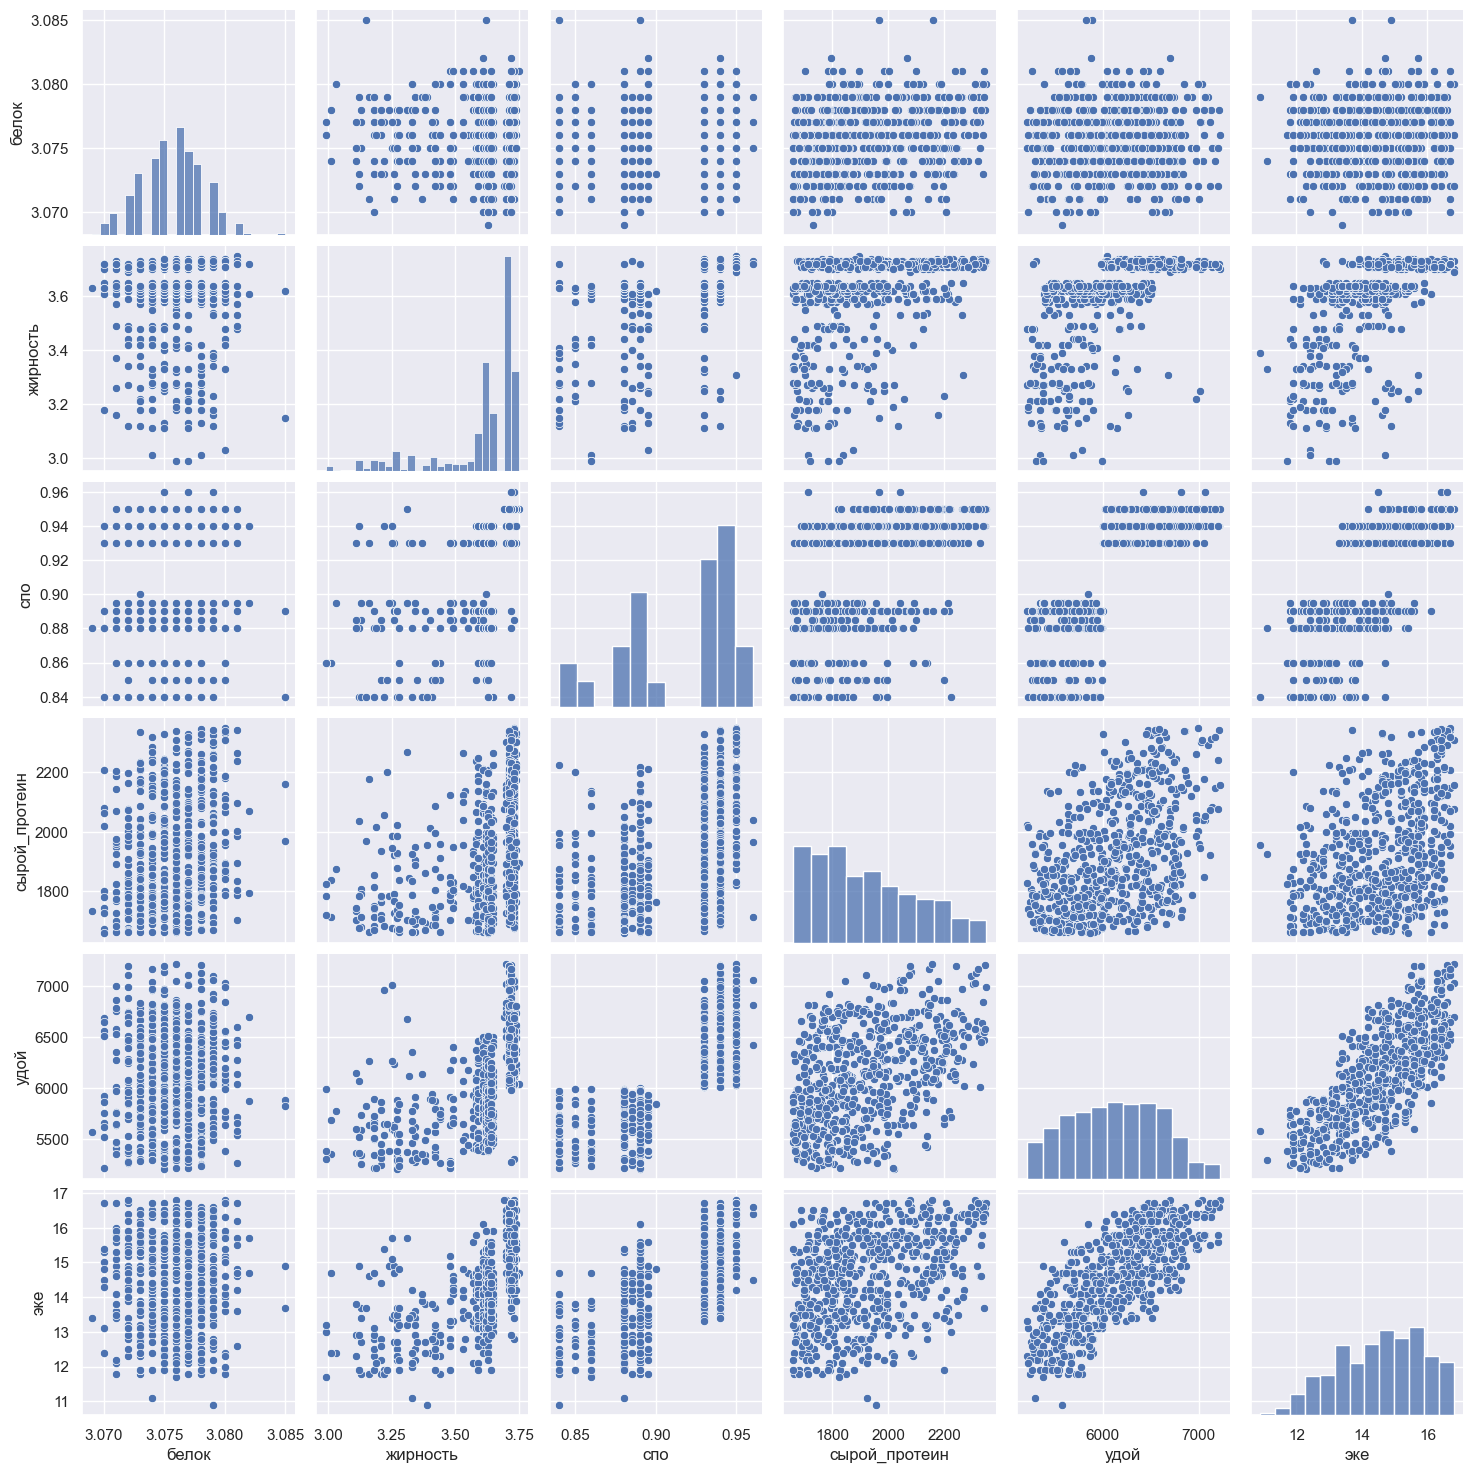

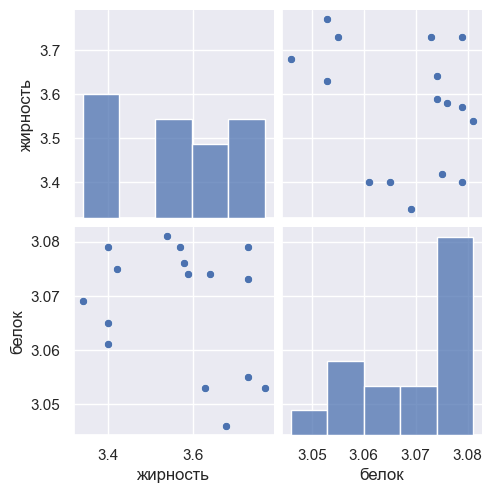

In [69]:
sns.pairplot(df_main_numeric);
sns.pairplot(df_buy_numeric);

Построены pairplots для попарных корреляций df_main_with_dad и df_buy
Вид некоторых диаграмм рассеяния - спо-удой; спо-эке - вызывает определенные вопросы так как при достаточно высокой корреляции их вид отличен от линейного. Предлагается сделать группировку по кат параметрам для df_main_with_dad и построить корр матрицы и pair plots для каждой группы

### 5.3 Построение диаграмм рассеяния по отдельным группам для df_main_with_dad

=============================== Группировка по колонке порода =================================
==== порода: Вис Бик Айдиал


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,0.000993,0.087881,0.231663,0.019052,0.028970
жирность,0.000993,1.000000,0.645536,0.363906,0.613211,0.635137
спо,0.087881,0.645536,1.000000,0.412295,0.799719,0.755809
сырой_протеин,0.231663,0.363906,0.412295,1.000000,0.422459,0.354303
удой,0.019052,0.613211,0.799719,0.422459,1.000000,0.768563
эке,0.028970,0.635137,0.755809,0.354303,0.768563,1.000000


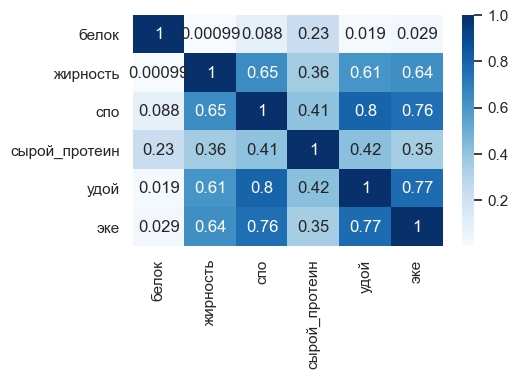

==== порода: РефлешнСоверинг


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,-0.031351,0.107608,0.249741,0.029123,0.004657
жирность,-0.031351,1.000000,0.601989,0.349396,0.581588,0.638039
спо,0.107608,0.601989,1.000000,0.499376,0.817124,0.735369
сырой_протеин,0.249741,0.349396,0.499376,1.000000,0.480929,0.441434
удой,0.029123,0.581588,0.817124,0.480929,1.000000,0.759908
эке,0.004657,0.638039,0.735369,0.441434,0.759908,1.000000


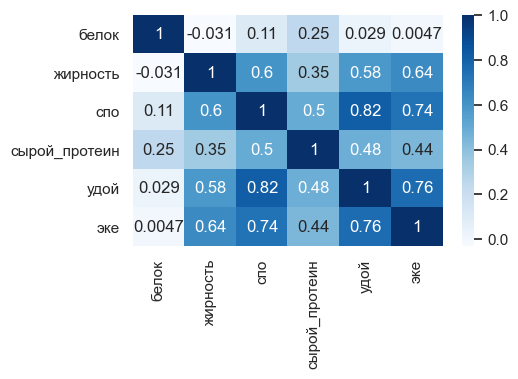

=============================== Группировка по колонке порода_папы_быка =================================
==== порода_папы_быка: Айдиал


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,-0.088346,-0.046909,0.222281,-0.099013,-0.100297
жирность,-0.088346,1.000000,0.683774,0.331300,0.688584,0.602833
спо,-0.046909,0.683774,1.000000,0.346540,0.779927,0.692684
сырой_протеин,0.222281,0.331300,0.346540,1.000000,0.427060,0.314016
удой,-0.099013,0.688584,0.779927,0.427060,1.000000,0.784784
эке,-0.100297,0.602833,0.692684,0.314016,0.784784,1.000000


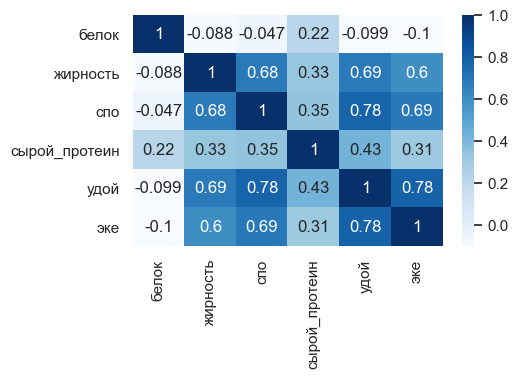

==== порода_папы_быка: Соверин


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,0.032959,0.167315,0.232080,0.076799,0.067242
жирность,0.032959,1.000000,0.599127,0.383130,0.589538,0.667063
спо,0.167315,0.599127,1.000000,0.552427,0.844454,0.792080
сырой_протеин,0.232080,0.383130,0.552427,1.000000,0.550694,0.456739
удой,0.076799,0.589538,0.844454,0.550694,1.000000,0.817542
эке,0.067242,0.667063,0.792080,0.456739,0.817542,1.000000


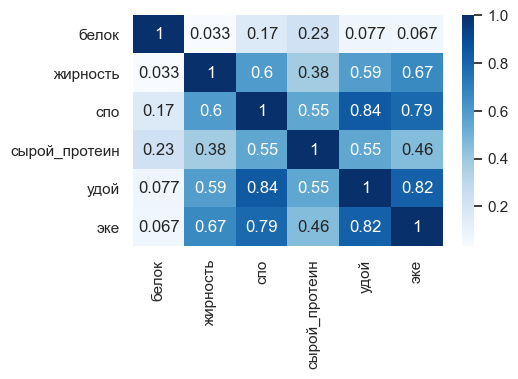

=============================== Группировка по колонке возраст =================================
==== возраст: более_2_лет


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,-0.036721,0.062405,0.237902,-0.018368,-0.023151
жирность,-0.036721,1.000000,0.600671,0.281131,0.492460,0.583086
спо,0.062405,0.600671,1.000000,0.390320,0.740982,0.692741
сырой_протеин,0.237902,0.281131,0.390320,1.000000,0.379561,0.322462
удой,-0.018368,0.492460,0.740982,0.379561,1.000000,0.670372
эке,-0.023151,0.583086,0.692741,0.322462,0.670372,1.000000


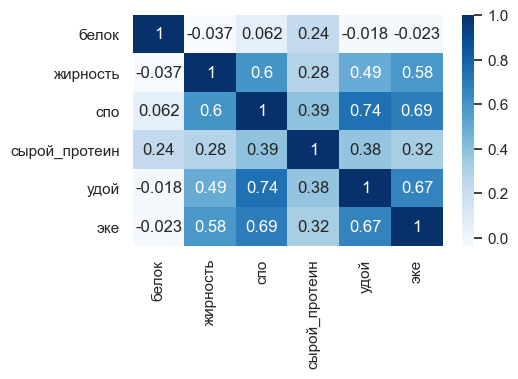

==== возраст: менее_2_лет


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,-0.049059,0.195853,0.219598,0.104620,-0.003486
жирность,-0.049059,1.000000,0.067898,0.208776,0.098369,0.216036
спо,0.195853,0.067898,1.000000,0.009990,0.186929,0.126683
сырой_протеин,0.219598,0.208776,0.009990,1.000000,-0.088534,-0.100392
удой,0.104620,0.098369,0.186929,-0.088534,1.000000,0.222663
эке,-0.003486,0.216036,0.126683,-0.100392,0.222663,1.000000


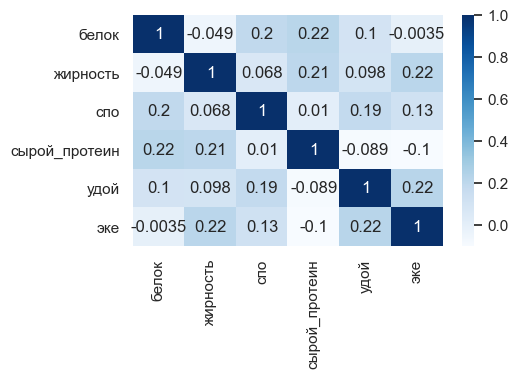

=============================== Группировка по колонке тип_пастбища =================================
==== тип_пастбища: равнинное


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,-0.008971,0.116116,0.231716,0.014018,0.037663
жирность,-0.008971,1.000000,0.667751,0.409616,0.688737,0.621664
спо,0.116116,0.667751,1.000000,0.428434,0.844841,0.747186
сырой_протеин,0.231716,0.409616,0.428434,1.000000,0.411266,0.353506
удой,0.014018,0.688737,0.844841,0.411266,1.000000,0.788518
эке,0.037663,0.621664,0.747186,0.353506,0.788518,1.000000


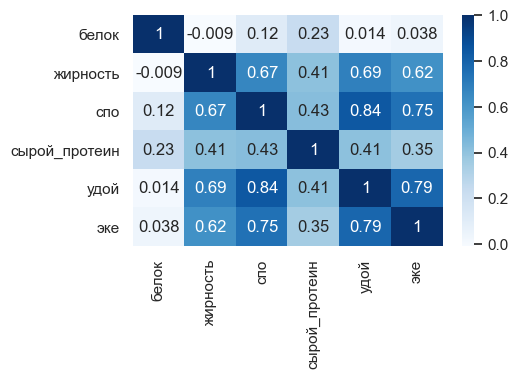

==== тип_пастбища: холмистое


,белок,жирность,спо,сырой_протеин,удой,эке
белок,1.000000,-0.036351,0.026661,0.212388,-0.030835,-0.068098
жирность,-0.036351,1.000000,0.604325,0.323555,0.555357,0.659218
спо,0.026661,0.604325,1.000000,0.456476,0.781955,0.748746
сырой_протеин,0.212388,0.323555,0.456476,1.000000,0.464935,0.407648
удой,-0.030835,0.555357,0.781955,0.464935,1.000000,0.745952
эке,-0.068098,0.659218,0.748746,0.407648,0.745952,1.000000


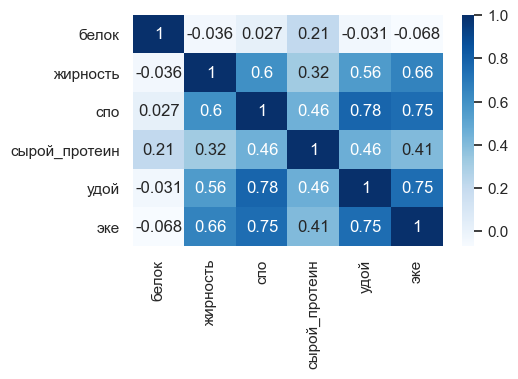

In [70]:
df_main_cat_col_list = ['порода', 'порода_папы_быка', 'возраст', 'тип_пастбища']

for col in df_main_cat_col_list:
    print(f'=============================== Группировка по колонке {col} =================================')
    df_main_with_dad_split_list = [y for x, y in df_main_with_dad.groupby(col)]
    for df in df_main_with_dad_split_list:
        print(f'==== {col}: {df[col].iloc[0]}')
        df_numeric = df.select_dtypes(include=np.number)
        df_numeric = df_numeric[df_numeric.columns.difference(['id'])]
        df_numeric_corr = df_numeric.corr()
        display(df_numeric_corr)
        plt.figure(figsize = (5,3))
        sns.heatmap(df_numeric_corr, cmap="Blues", annot=True)
        plt.show()

### 5.4 Выводы о взаимосвязи признаков

## 6. Задача регрессии

### 6.1 Первая модель регрессии

### 6.2 Вторая модель регрессии

### 6.3 Третья модель регрессии

### 6.4 Сравнение качества трёх моделей линейной регрессии

### 6.5 Выбор лучшей модели и прогноз характеристики **Удой**

## 7. Задача классификации

### 7.1 Обучение модели LogisticRegression

### 7.2 Анализ модели LogisticRegression

### 7.3 С помощью обученной модели LogisticRegression спрогнозировать параметр **Вкус молока** коров, которых фермер хочет купить.

## 8. Выводы